In [3]:
%%time
# Based on this wonderful notebook by Peter - https://www.kaggle.com/peterhurford/lgb-and-fm-18th-place-0-40604
import time
start_time = time.time()

# Use SUBMIT_MODE = False to tune your script!
# Use SUBMIT_MODE = True to generate a submission for Kaggle.
SUBMIT_MODE = True

import pandas as pd
import numpy as np
import time
import gc
import string
import re

from nltk.corpus import stopwords

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelBinarizer

import wordbatch
from wordbatch.extractors import WordBag
from wordbatch.models import FM_FTRL

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

def rmse(predicted, actual):
    return np.sqrt(((predicted - actual) ** 2).mean())

CPU times: user 170 ms, sys: 23 ms, total: 193 ms
Wall time: 512 ms


In [4]:
%%time

class TargetEncoder:
    # Adapted from https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
    def __repr__(self):
        return 'TargetEncoder'

    def __init__(self, cols, smoothing=1, min_samples_leaf=1, noise_level=0, keep_original=False):
        self.cols = cols
        self.smoothing = smoothing
        self.min_samples_leaf = min_samples_leaf
        self.noise_level = noise_level
        self.keep_original = keep_original

    @staticmethod
    def add_noise(series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def encode(self, train, test, target):
        for col in self.cols:
            if self.keep_original:
                train[col + '_te'], test[col + '_te'] = self.encode_column(train[col], test[col], target)
            else:
                train[col], test[col] = self.encode_column(train[col], test[col], target)
        return train, test

    def encode_column(self, trn_series, tst_series, target):
        temp = pd.concat([trn_series, target], axis=1)
        # Compute target mean
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        # Compute smoothing
        smoothing = 1 / (1 + np.exp(-(averages["count"] - self.min_samples_leaf) / self.smoothing))
        # Apply average function to all target data
        prior = target.mean()
        # The bigger the count the less full_avg is taken into account
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(['mean', 'count'], axis=1, inplace=True)
        # Apply averages to trn and tst series
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_trn_series.index = trn_series.index
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_tst_series.index = tst_series.index
        return self.add_noise(ft_trn_series, self.noise_level), self.add_noise(ft_tst_series, self.noise_level)

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 45.5 µs


In [9]:
%%time
# Define helpers for text normalization
stopwords = {x: 1 for x in stopwords.words('russian')}
non_alphanums = re.compile(u'[^A-Za-z0-9]+')
non_alphanumpunct = re.compile(u'[^A-Za-z0-9\.?!,; \(\)\[\]\'\"\$]+')
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])

CPU times: user 2.13 ms, sys: 292 µs, total: 2.42 ms
Wall time: 1.63 ms


In [10]:


%%time
train = pd.read_csv('~/.kaggle/competitions/avito-demand-prediction/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
test = pd.read_csv('~/.kaggle/competitions/avito-demand-prediction/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
print('[{}] Finished load data'.format(time.time() - start_time))

[1303.6727406978607] Finished load data
CPU times: user 19.7 s, sys: 1.45 s, total: 21.2 s
Wall time: 22 s


In [11]:
%%time
import string

def normalize_text(text):
    text = text.lower().strip()
    for s in string.punctuation:
        text = text.replace(s, ' ')
    text = text.strip().split(' ')
    return u' '.join(x for x in text if len(x) > 1 and x not in stopwords)

print(train.description[0])
print(normalize_text(train.description[0]))

Кокон для сна малыша,пользовались меньше месяца.цвет серый
кокон сна малыша пользовались меньше месяца цвет серый
CPU times: user 497 ms, sys: 2.94 ms, total: 499 ms
Wall time: 511 ms


In [12]:
%%time
train['is_train'] = 1
test['is_train'] = 0
print('[{}] Compiled train / test'.format(time.time() - start_time))
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

y = train.deal_probability.copy()
nrow_train = train.shape[0]

merge = pd.concat([train, test])
submission = pd.DataFrame(test.index)
print('[{}] Compiled merge'.format(time.time() - start_time))
print('Merge shape: ', merge.shape)

del train
del test
gc.collect()
print('[{}] Garbage collection'.format(time.time() - start_time))

[3500.31697678566] Compiled train / test
Train shape:  (1503424, 18)
Test shape:  (508438, 17)
[3501.2301795482635] Compiled merge
Merge shape:  (2011862, 18)
[3501.4163954257965] Garbage collection
CPU times: user 816 ms, sys: 273 ms, total: 1.09 s
Wall time: 1.1 s


In [13]:
%%time
print("Feature Engineering - Part 1")
merge["price"] = np.log(merge["price"]+0.001)
merge["price"].fillna(-999,inplace=True)
merge["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
merge["activation_weekday"] = merge['activation_date'].dt.weekday
print(merge.head(5))
gc.collect()

Feature Engineering - Part 1

Create Time Variables
             activation_date               category_name              city  \
item_id                                                                      
b912c3c6a6ad      2017-03-28  Товары для детей и игрушки      Екатеринбург   
2dac0150717d      2017-03-26           Мебель и интерьер            Самара   
ba83aefab5dc      2017-03-20               Аудио и видео    Ростов-на-Дону   
02996f1dd2ea      2017-03-25  Товары для детей и игрушки  Набережные Челны   
7c90be56d2ab      2017-03-16                  Автомобили         Волгоград   

              deal_probability  \
item_id                          
b912c3c6a6ad           0.12789   
2dac0150717d           0.00000   
ba83aefab5dc           0.43177   
02996f1dd2ea           0.80323   
7c90be56d2ab           0.20797   

                                                    description  \
item_id                                                           
b912c3c6a6ad  Кокон для сна 

In [14]:
%%time
# Create Validation Index and Remove Dead Variables
training_index = merge.loc[merge.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = merge.loc[merge.activation_date>=pd.to_datetime('2017-04-08')].index
merge.drop(["activation_date","image"],axis=1,inplace=True)

#Drop user_id
merge.drop(["user_id"], axis=1,inplace=True)

CPU times: user 1.68 s, sys: 839 ms, total: 2.51 s
Wall time: 2.53 s


In [15]:
%%time

# Meta Text Features
print("\nText Features")
textfeats = ["description", "title"]

for cols in textfeats:
    merge[cols] = merge[cols].astype(str) 
    merge[cols] = merge[cols].astype(str).fillna('missing') # FILL NA
    merge[cols] = merge[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    merge[cols + '_num_stopwords'] = merge[cols].apply(lambda x: len([w for w in x.split() if w in stopwords])) # Count number of Stopwords
    merge[cols + '_num_punctuations'] = merge[cols].apply(lambda comment: (comment.count(RE_PUNCTUATION))) # Count number of Punctuations
    merge[cols + '_num_alphabets'] = merge[cols].apply(lambda comment: len([c for c in comment if c.isupper()])) # Count number of Alphabets
    merge[cols + '_num_digits'] = merge[cols].apply(lambda comment: (comment.count('[0-9]'))) # Count number of Digits
    merge[cols + '_num_letters'] = merge[cols].apply(lambda comment: len(comment)) # Count number of Letters
    merge[cols + '_num_words'] = merge[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    merge[cols + '_num_unique_words'] = merge[cols].apply(lambda comment: len(set(w for w in comment.split())))
    merge[cols + '_words_vs_unique'] = merge[cols+'_num_unique_words'] / merge[cols+'_num_words'] # Count Unique Words
    merge[cols + '_letters_per_word'] = merge[cols+'_num_letters'] / merge[cols+'_num_words'] # Letters per Word
    merge[cols + '_punctuations_by_letters'] = merge[cols+'_num_punctuations'] / merge[cols+'_num_letters'] # Punctuations by Letters
    merge[cols + '_punctuations_by_words'] = merge[cols+'_num_punctuations'] / merge[cols+'_num_words'] # Punctuations by Words
    merge[cols + '_digits_by_letters'] = merge[cols+'_num_digits'] / merge[cols+'_num_letters'] # Digits by Letters
    merge[cols + '_alphabets_by_letters'] = merge[cols+'_num_alphabets'] / merge[cols+'_num_letters'] # Alphabets by Letters
    merge[cols + '_stopwords_by_words'] = merge[cols+'_num_stopwords'] / merge[cols+'_num_words'] # Stopwords by Letters
    merge[cols + '_mean'] = merge[cols].apply(lambda x: 0 if len(x) == 0 else float(len(x.split())) / len(x)) * 10 # Mean

# Extra Feature Engineering
merge['title_desc_len_ratio'] = merge['title_num_letters']/merge['description_num_letters']


Text Features
CPU times: user 1min 42s, sys: 1.22 s, total: 1min 43s
Wall time: 1min 43s


In [16]:
merge.head()

,category_name,city,deal_probability,description,image_top_1,is_train,item_seq_number,param_1,param_2,param_3,...,title_num_unique_words,title_words_vs_unique,title_letters_per_word,title_punctuations_by_letters,title_punctuations_by_words,title_digits_by_letters,title_alphabets_by_letters,title_stopwords_by_words,title_mean,title_desc_len_ratio
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,Товары для детей и игрушки,Екатеринбург,0.12789,"кокон для сна малыша,пользовались меньше месяц...",1008.0,1,2,Постельные принадлежности,NaN,NaN,...,3,1.0,7.000000,0.0,0.0,0.0,0.0,0.333333,1.428571,0.362069
2dac0150717d,Мебель и интерьер,Самара,0.00000,"стойка для одежды, под вешалки. с бутика.",692.0,1,19,Другое,NaN,NaN,...,3,1.0,5.666667,0.0,0.0,0.0,0.0,0.333333,1.764706,0.414634
ba83aefab5dc,Аудио и видео,Ростов-на-Дону,0.43177,"в хорошем состоянии, домашний кинотеатр с blu ...",3032.0,1,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,...,2,1.0,7.000000,0.0,0.0,0.0,0.0,0.000000,1.428571,0.141414
02996f1dd2ea,Товары для детей и игрушки,Набережные Челны,0.80323,продам кресло от0-25кг,796.0,1,286,Автомобильные кресла,NaN,NaN,...,1,1.0,10.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.454545
7c90be56d2ab,Автомобили,Волгоград,0.20797,все вопросы по телефону.,2264.0,1,3,С пробегом,ВАЗ (LADA),2110,...,3,1.0,4.666667,0.0,0.0,0.0,0.0,0.000000,2.142857,0.583333


In [17]:
%%time
df_test = merge.loc[merge['is_train'] == 0]
df_train = merge.loc[merge['is_train'] == 1]
del merge
gc.collect()
df_test = df_test.drop(['is_train'], axis=1)
df_train = df_train.drop(['is_train'], axis=1)

print(df_train.shape)
print(y.shape)

if SUBMIT_MODE:
    y_train = y
    del y
    gc.collect()
else:
    df_train, df_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=144)

print('[{}] Splitting completed.'.format(time.time() - start_time))

(1503424, 46)
(1503424,)
[3738.032951593399] Splitting completed.
CPU times: user 987 ms, sys: 1.14 s, total: 2.13 s
Wall time: 2.13 s


In [18]:
%%time
wb = wordbatch.WordBatch(normalize_text, extractor=(WordBag, {"hash_ngrams": 2,
                                                              "hash_ngrams_weights": [1.5, 1.0],
                                                              "hash_size": 2 ** 29,
                                                              "norm": None,
                                                              "tf": 'binary',
                                                              "idf": None,
                                                              }), procs=8)
wb.dictionary_freeze = True
X_name_train = wb.fit_transform(df_train['title'])
print(X_name_train.shape)
X_name_test = wb.transform(df_test['title'])
print(X_name_test.shape)
del(wb)
gc.collect()

Normalize text
Extract wordbags
(1503424, 536870912)
Normalize text
Extract wordbags
(508438, 536870912)
CPU times: user 3.24 s, sys: 3.72 s, total: 6.96 s
Wall time: 1min 28s


In [19]:
%%time
mask = np.where(X_name_train.getnnz(axis=0) > 3)[0]
X_name_train = X_name_train[:, mask]
print(X_name_train.shape)
X_name_test = X_name_test[:, mask]
print(X_name_test.shape)
print('[{}] Vectorize `title` completed.'.format(time.time() - start_time))

(1503424, 130898)
(508438, 130898)
[3916.259336233139] Vectorize `title` completed.
CPU times: user 7.9 s, sys: 7.16 s, total: 15.1 s
Wall time: 15.1 s


In [20]:
%%time
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_name_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

model = Ridge(solver="sag", fit_intercept=True, random_state=42, alpha=5)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train name ridge (1)'.format(time.time() - start_time))
name_ridge_preds1 = model.predict(X_train_2)
name_ridge_preds1f = model.predict(X_name_test)
print('[{}] Finished to predict name ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=42, alpha=5)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train name ridge (2)'.format(time.time() - start_time))
name_ridge_preds2 = model.predict(X_train_1)
name_ridge_preds2f = model.predict(X_name_test)
print('[{}] Finished to predict name ridge (2)'.format(time.time() - start_time))
name_ridge_preds_oof = np.concatenate((name_ridge_preds2, name_ridge_preds1), axis=0)
name_ridge_preds_test = (name_ridge_preds1f + name_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(name_ridge_preds_oof, y_train)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(name_ridge_preds_test, y_test)))
gc.collect()

[3920.7799084186554] Finished splitting
[3937.824908018112] Finished to train name ridge (1)
[3937.8556027412415] Finished to predict name ridge (1)
[3953.834986925125] Finished to train name ridge (2)
[3953.8730533123016] Finished to predict name ridge (2)
RMSLE OOF: 0.23861657781071718
CPU times: user 33.9 s, sys: 165 ms, total: 34.1 s
Wall time: 34 s


In [22]:
%%time
wb = wordbatch.WordBatch(normalize_text, extractor=(WordBag, {"hash_ngrams": 2,
                                                              "hash_ngrams_weights": [1.0, 1.0],
                                                              "hash_size": 2 ** 28,
                                                              "norm": "l2",
                                                              "tf": 1.0,
                                                              "idf": None}), procs=8)
wb.dictionary_freeze = True
X_description_train = wb.fit_transform(df_train['description'].fillna(''))
print(X_description_train.shape)
X_description_test = wb.transform(df_test['description'].fillna(''))
print(X_description_test.shape)
print('-')
del(wb)
gc.collect()

Normalize text
Extract wordbags
(1503424, 268435456)
Normalize text
Extract wordbags
(508438, 268435456)
-
CPU times: user 9.87 s, sys: 11.8 s, total: 21.7 s
Wall time: 2min 39s


In [23]:
%%time
mask = np.where(X_description_train.getnnz(axis=0) > 8)[0]
X_description_train = X_description_train[:, mask]
print(X_description_train.shape)
X_description_test = X_description_test[:, mask]
print(X_description_test.shape)
print('[{}] Vectorize `description` completed.'.format(time.time() - start_time))

(1503424, 460202)
(508438, 460202)
[4456.663789510727] Vectorize `description` completed.
CPU times: user 33.7 s, sys: 4.57 s, total: 38.3 s
Wall time: 38.3 s


In [24]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_description_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

# Ridge adapted from https://www.kaggle.com/object/more-effective-ridge-script?scriptVersionId=1851819
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train desc ridge (1)'.format(time.time() - start_time))
desc_ridge_preds1 = model.predict(X_train_2)
desc_ridge_preds1f = model.predict(X_description_test)
print('[{}] Finished to predict desc ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train desc ridge (2)'.format(time.time() - start_time))
desc_ridge_preds2 = model.predict(X_train_1)
desc_ridge_preds2f = model.predict(X_description_test)
print('[{}] Finished to predict desc ridge (2)'.format(time.time() - start_time))
desc_ridge_preds_oof = np.concatenate((desc_ridge_preds2, desc_ridge_preds1), axis=0)
desc_ridge_preds_test = (desc_ridge_preds1f + desc_ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(desc_ridge_preds_oof, y_train)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(desc_ridge_preds_test, y_test)))
gc.collect()

[4691.502896785736] Finished splitting
[4715.313063621521] Finished to train desc ridge (1)
[4715.5176322460175] Finished to predict desc ridge (1)
[4739.842818260193] Finished to train desc ridge (2)
[4740.040509939194] Finished to predict desc ridge (2)
RMSLE OOF: 0.23582078721065589


22

In [25]:
del X_train_1
del X_train_2
del y_train_1
del y_train_2
del name_ridge_preds1
del name_ridge_preds1f
del name_ridge_preds2
del name_ridge_preds2f
del desc_ridge_preds1
del desc_ridge_preds1f
del desc_ridge_preds2
del desc_ridge_preds2f
gc.collect()
print('[{}] Finished garbage collection'.format(time.time() - start_time))

[5048.224899530411] Finished garbage collection


In [26]:
%%time
df_train.drop(['deal_probability', 'title', 'description'], axis=1, inplace=True)
df_test.drop(['title', 'description'], axis=1, inplace=True)
print('Remerged')

dummy_cols = ['parent_category_name', 'category_name', 'user_type', 'image_top_1',
            'region', 'city', 'param_1', 'param_2', 'param_3', 'activation_weekday']
numeric_cols = list(set(df_train.columns.values) - set(dummy_cols))
print(numeric_cols)

Remerged
['title_words_vs_unique', 'description_mean', 'title_desc_len_ratio', 'price', 'item_seq_number', 'title_num_words', 'title_alphabets_by_letters', 'description_digits_by_letters', 'title_num_alphabets', 'title_num_stopwords', 'description_punctuations_by_letters', 'title_mean', 'title_digits_by_letters', 'description_num_words', 'title_punctuations_by_letters', 'description_num_stopwords', 'description_punctuations_by_words', 'title_num_letters', 'description_num_alphabets', 'description_num_letters', 'title_num_digits', 'title_num_punctuations', 'description_num_unique_words', 'description_words_vs_unique', 'description_num_digits', 'description_stopwords_by_words', 'title_punctuations_by_words', 'description_num_punctuations', 'description_letters_per_word', 'description_alphabets_by_letters', 'title_num_unique_words', 'title_letters_per_word', 'title_stopwords_by_words']
CPU times: user 317 ms, sys: 408 ms, total: 725 ms
Wall time: 721 ms


In [27]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# https://stackoverflow.com/questions/37685412/avoid-scaling-binary-columns-in-sci-kit-learn-standsardscaler
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy, with_mean, with_std)
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns, index=X.index)
        X_not_scaled = X[list(set(init_col_order) - set(self.columns))]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

print('Scaler')
scaler = Scaler(columns=numeric_cols)
df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)

Scaler
CPU times: user 2.11 s, sys: 3.11 s, total: 5.23 s
Wall time: 5.22 s


In [28]:
df_train.head()

,category_name,city,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,...,title_num_unique_words,title_words_vs_unique,title_letters_per_word,title_punctuations_by_letters,title_punctuations_by_words,title_digits_by_letters,title_alphabets_by_letters,title_stopwords_by_words,title_mean,title_desc_len_ratio
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,Товары для детей и игрушки,Екатеринбург,1008.0,-0.133095,Постельные принадлежности,NaN,NaN,Личные вещи,0.237438,Свердловская область,...,-0.174049,0.069167,0.100569,0.0,0.0,0.0,0.0,2.613470,-0.371229,-0.206780
2dac0150717d,Мебель и интерьер,Самара,692.0,-0.130044,Другое,NaN,NaN,Для дома и дачи,0.246085,Самарская область,...,-0.174049,0.069167,-0.540493,0.0,0.0,0.0,0.0,2.613470,0.398994,-0.180563
ba83aefab5dc,Аудио и видео,Ростов-на-Дону,3032.0,-0.131839,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,0.247320,Ростовская область,...,-0.718742,0.069167,0.100569,0.0,0.0,0.0,0.0,-0.486187,-0.371229,-0.316833
02996f1dd2ea,Товары для детей и игрушки,Набережные Челны,796.0,-0.082131,Автомобильные кресла,NaN,NaN,Личные вещи,0.244754,Татарстан,...,-1.263436,0.069167,1.542957,0.0,0.0,0.0,0.0,-0.486187,-1.353265,-0.160657
7c90be56d2ab,Автомобили,Волгоград,2264.0,-0.132915,С пробегом,ВАЗ (LADA),2110,Транспорт,0.257201,Волгоградская область,...,-0.174049,0.069167,-1.021289,0.0,0.0,0.0,0.0,-0.486187,1.265496,-0.096423


In [29]:
%%time
from sklearn.preprocessing import LabelBinarizer

sparse_merge_train = hstack((X_name_train, X_description_train)).tocsr()
sparse_merge_test = hstack((X_name_test, X_description_test)).tocsr()
print(sparse_merge_train.shape)
for col in dummy_cols:
    print(col)
    lb = LabelBinarizer(sparse_output=True)
    sparse_merge_train = hstack((sparse_merge_train, lb.fit_transform(df_train[[col]].fillna('')))).tocsr()
    print(sparse_merge_train.shape)
    sparse_merge_test = hstack((sparse_merge_test, lb.transform(df_test[[col]].fillna('')))).tocsr()

(1503424, 591100)
parent_category_name
(1503424, 591109)
category_name
(1503424, 591156)
user_type
(1503424, 591159)
image_top_1
(1503424, 594222)
region
(1503424, 594250)
city
(1503424, 595983)
param_1
(1503424, 596355)
param_2
(1503424, 596627)
param_3
(1503424, 597847)
activation_weekday
(1503424, 597854)
CPU times: user 3min 25s, sys: 19.3 s, total: 3min 45s
Wall time: 3min 45s


In [30]:
del X_description_test, X_name_test
del X_description_train, X_name_train
del lb, mask
gc.collect()

196

In [31]:
%%time
print("\n FM_FTRL Starting...........")
if SUBMIT_MODE:
    iters = 1
else:
    iters = 1
    rounds = 1

model = FM_FTRL(alpha=0.035, beta=0.001, L1=0.00001, L2=0.15, D=sparse_merge_train.shape[1],
                alpha_fm=0.05, L2_fm=0.0, init_fm=0.01,
                D_fm=100, e_noise=0, iters=iters, inv_link="identity", threads=4)

if SUBMIT_MODE:
    model.fit(sparse_merge_train, y_train)
    print('[{}] Train FM completed'.format(time.time() - start_time))
    predsFM = model.predict(sparse_merge_test)
    print('[{}] Predict FM completed'.format(time.time() - start_time))
else:
    for i in range(rounds):
        model.fit(sparse_merge_train, y_train)
        predsFM = model.predict(sparse_merge_test)
        print('[{}] Iteration {}/{} -- RMSLE: {}'.format(time.time() - start_time, i + 1, rounds, rmse(predsFM, y_test)))

del model
gc.collect()
if not SUBMIT_MODE:
    print("FM_FTRL dev RMSLE:", rmse(predsFM, y_test))
# 0.23046 in 1/3


 FM_FTRL Starting...........
[5420.126853942871] Train FM completed
[5427.818638801575] Predict FM completed
CPU times: user 2min 5s, sys: 44.6 s, total: 2min 50s
Wall time: 43.6 s


In [32]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(sparse_merge_train, y_train,
                                                              test_size = 0.5,
                                                              shuffle = False)
print('[{}] Finished splitting'.format(time.time() - start_time))

model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_1, y_train_1)
print('[{}] Finished to train ridge (1)'.format(time.time() - start_time))
ridge_preds1 = model.predict(X_train_2)
ridge_preds1f = model.predict(sparse_merge_test)
print('[{}] Finished to predict ridge (1)'.format(time.time() - start_time))
model = Ridge(solver="sag", fit_intercept=True, random_state=205, alpha=3.3)
model.fit(X_train_2, y_train_2)
print('[{}] Finished to train ridge (2)'.format(time.time() - start_time))
ridge_preds2 = model.predict(X_train_1)
ridge_preds2f = model.predict(sparse_merge_test)
print('[{}] Finished to predict ridge (2)'.format(time.time() - start_time))
ridge_preds_oof = np.concatenate((ridge_preds2, ridge_preds1), axis=0)
ridge_preds_test = (ridge_preds1f + ridge_preds2f) / 2.0
print('RMSLE OOF: {}'.format(rmse(ridge_preds_oof, y_train)))
if not SUBMIT_MODE:
    print('RMSLE TEST: {}'.format(rmse(ridge_preds_test, y_test)))

[5436.23700594902] Finished splitting
[5518.239964008331] Finished to train ridge (1)
[5518.523268222809] Finished to predict ridge (1)
[5598.433698892593] Finished to train ridge (2)
[5598.71185874939] Finished to predict ridge (2)
RMSLE OOF: 0.23342334067442383


In [33]:
fselect = SelectKBest(f_regression, k=48000)
train_features = fselect.fit_transform(sparse_merge_train, y_train)
test_features = fselect.transform(sparse_merge_test)
print('[{}] Select best completed'.format(time.time() - start_time))


del sparse_merge_train
del sparse_merge_test
gc.collect()
print('[{}] Garbage collection'.format(time.time() - start_time))

[5696.191174983978] Select best completed
[5696.29104590416] Garbage collection


In [34]:
del ridge_preds1
del ridge_preds1f
del ridge_preds2
del ridge_preds2f
del X_train_1
del X_train_2
del y_train_1
del y_train_2
del model
gc.collect()
print('[{}] Finished garbage collection'.format(time.time() - start_time))

[5765.737865924835] Finished garbage collection


In [35]:
df_train['ridge'] = ridge_preds_oof
df_train['name_ridge'] = name_ridge_preds_oof
df_train['desc_ridge'] = desc_ridge_preds_oof
df_test['ridge'] = ridge_preds_test
df_test['name_ridge'] = name_ridge_preds_test
df_test['desc_ridge'] = desc_ridge_preds_test
print('[{}] Finished adding submodels'.format(time.time() - start_time))

[5771.701657295227] Finished adding submodels


In [36]:
f_cats = ["region","city","parent_category_name","category_name","user_type","image_top_1"]
target_encode = TargetEncoder(min_samples_leaf=100, smoothing=10, noise_level=0.01,
                              keep_original=True, cols=f_cats)
df_train, df_test = target_encode.encode(df_train, df_test, y_train)
print('[{}] Finished target encoding'.format(time.time() - start_time))

[5785.647529840469] Finished target encoding


In [37]:
del ridge_preds_oof
del ridge_preds_test
gc.collect()
print('[{}] Finished garbage collection'.format(time.time() - start_time))

[5805.613148927689] Finished garbage collection


In [38]:
cols = ['region_te', 'city_te', 'parent_category_name_te', 'category_name_te',
        'user_type_te', 'image_top_1_te', 'desc_ridge', 'name_ridge', 'ridge']
train_dummies = csr_matrix(df_train[cols].values)
print('[{}] Finished dummyizing model 1/5'.format(time.time() - start_time))
test_dummies = csr_matrix(df_test[cols].values)
print('[{}] Finished dummyizing model 2/5'.format(time.time() - start_time))
del df_train
del df_test
gc.collect()
print('[{}] Finished dummyizing model 3/5'.format(time.time() - start_time))
train_features = hstack((train_features, train_dummies)).tocsr()
print('[{}] Finished dummyizing model 4/5'.format(time.time() - start_time))
test_features = hstack((test_features, test_dummies)).tocsr()
print('[{}] Finished dummyizing model 5/5'.format(time.time() - start_time))

[5859.820460319519] Finished dummyizing model 1/5
[5860.303211688995] Finished dummyizing model 2/5
[5860.414610862732] Finished dummyizing model 3/5
[5864.654233217239] Finished dummyizing model 4/5
[5866.068094491959] Finished dummyizing model 5/5


In [39]:
d_train = lgb.Dataset(train_features, label=y_train)
del train_features
gc.collect()
if SUBMIT_MODE:
    watchlist = [d_train]
else:
    d_valid = lgb.Dataset(test_features, label=y_test)
    watchlist = [d_train, d_valid]

params = {
    'learning_rate': 0.15,
    'application': 'regression',
    'max_depth': 13,
    'num_leaves': 400,
    'verbosity': -1,
    'metric': 'RMSE',
    'data_random_seed': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.6,
    'nthread': 4,
    'lambda_l1': 10,
    'lambda_l2': 10
}
print('[{}] Finished compiling LGB'.format(time.time() - start_time))

[5868.263060331345] Finished compiling LGB


In [40]:
%%time
modelL = lgb.train(params,
                  train_set=d_train,
                  num_boost_round=400,
                  valid_sets=watchlist,
                  verbose_eval=50)

predsL = modelL.predict(test_features)
predsL[predsL < 0] = 0
predsL[predsL > 1] = 1

if not SUBMIT_MODE:
    print("LGB RMSLE:", rmse(predsL, y_test))

[50]	training's rmse: 0.222998
[100]	training's rmse: 0.221688
[150]	training's rmse: 0.220429
[200]	training's rmse: 0.219469
[250]	training's rmse: 0.218634
[300]	training's rmse: 0.217682
[350]	training's rmse: 0.216915
[400]	training's rmse: 0.216191
CPU times: user 22min 50s, sys: 1min 45s, total: 24min 36s
Wall time: 6min 11s


In [41]:
del d_train
del modelL
if not SUBMIT_MODE:
    del d_valid
gc.collect()

259

In [42]:
preds_final = predsFM * 0.1 + predsL * 0.9
if not SUBMIT_MODE:
    print('Final RMSE: ', rmse(preds_final, y_test))

In [43]:
if SUBMIT_MODE:
    submission['deal_probability'] = preds_final
    submission['deal_probability'] = submission['deal_probability'].clip(0.0, 1.0) # Between 0 and 1
    submission.to_csv('avito_lgb_and_fm_separate_train_test.csv', index=False)
    print('[{}] Writing submission done'.format(time.time() - start_time))
    print(submission.head(5))

[6639.105021238327] Writing submission done
        item_id  deal_probability
0  6544e41a8817          0.331394
1  65b9484d670f          0.140761
2  8bab230b2ecd          0.220724
3  8e348601fefc          0.118443
4  8bd2fe400b89          0.230886


Data:
 ['train_active.csv.zip', 'train.csv', 'periods_test.csv', 'train_jpg_0.zip', 'train_active.csv', 'test_active.csv.zip', 'test_active.csv', 'periods_test.csv.zip', 'test.csv', 'train.csv.zip', 'periods_train.csv', 'test.csv.zip', 'periods_train.csv.zip']

Data Load Stage


/home/luanhongwei/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns
Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']

Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 8.48 Minutes

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23034390282097936
Modeling Stage
1503424 Rows and 1430783 Cols
508438 Rows and 1430783 Cols
Feature Names Length:  1430783

Modeling Stage
Light Gradient Boosting Regressor


/home/luanhongwei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


/home/luanhongwei/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Notebook Runtime: 97.21 Minutes


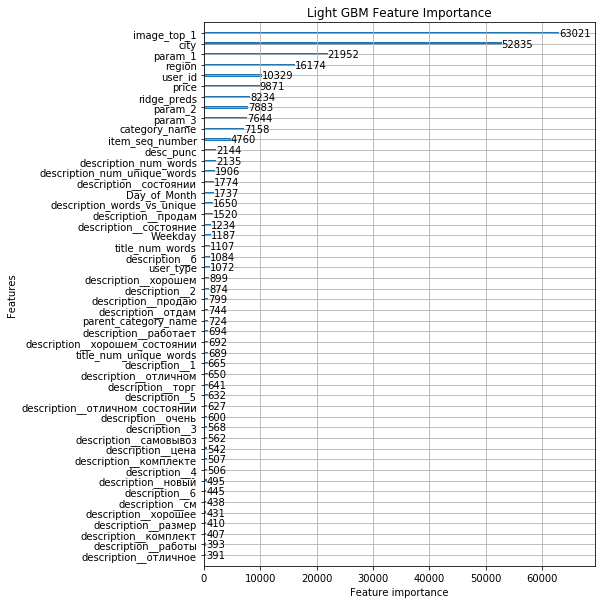

In [51]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
print("Data:\n",os.listdir(".kaggle/competitions/avito-demand-prediction/"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

NFOLDS = 5
SEED = 42
VALID = True
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

print("\nData Load Stage")
training = pd.read_csv('~/.kaggle/competitions/avito-demand-prediction/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('~/.kaggle/competitions/avito-demand-prediction/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index

ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))


print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])
    
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))

print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

print("\nModeling Stage")

del ridge_preds,vectorizer,ready_df
gc.collect();
    
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.016,
    'verbose': 0
}  


if VALID == False:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=23)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1550,
        verbose_eval=100
    )



# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

In [50]:
os.listdir(".kaggle/competitions/avito-demand-prediction/")

['train_active.csv.zip',
 'train.csv',
 'periods_test.csv',
 'train_jpg_0.zip',
 'train_active.csv',
 'test_active.csv.zip',
 'test_active.csv',
 'periods_test.csv.zip',
 'test.csv',
 'train.csv.zip',
 'periods_train.csv',
 'test.csv.zip',
 'periods_train.csv.zip']

In [1]:
import numpy as np
import pandas as pd
import math
import time
import os.path

In [12]:
d1=pd.read_csv('C:\\Users\\hluan\\Downloads\\subavito2_blend.csv')

In [13]:
d2=pd.read_csv('C:\\Users\\hluan\\Downloads\\submission.csv')

In [14]:
d2['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [15]:
d1['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [16]:
d2['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [17]:
d1['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [18]:
d2['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [19]:
d1['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [20]:
d2['deal_probability']=(d1['deal_probability']+d2['deal_probability'])/2

In [21]:
d2.to_csv("submissionavito.csv", index=False)